In [5]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
import sys
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import PathCollection

from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

from scipy.optimize import curve_fit

module_name = "utils_v2"
file_path = "/workspaces/TP3/utils_v2.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

# Importer le module
import utils_v2 as u

import pandas as pd

In [6]:
def linear_fit(x, a, b):
    return a * x + b

d_err = 0.2

# Langmuir 1


$$V_P = \frac{b_2-b_1}{a_1-a_2}$$

$$dV_P = \left|\frac{db_2 + db_1}{a_1-a_2}\right| + \left|\frac{b_2-b_1}{(a_1-a_2)^2} (da_1 + da_2)\right|$$


$$ln(I_{es}) = a_1 V_P + b_1$$
$$dln(I_{es}) = a_1 dV_P + da_1 V_P + db_1$$
$$dI_{es} = I_{es} dln(I_{es})$$


$$T=\frac{e}{k_B s}$$

$$dT = \frac{1}{k_B s^2} =T \frac{ds}{s}$$

$$n = \frac{1}{eA_p} \sqrt{\frac{2\pi m_e}{k_B}}\frac{}{\sqrt{T}} I_{es}$$

$$dn = \frac{1}{eA_p} \sqrt{\frac{2\pi m_e}{k_B}}\frac{}{\sqrt{T}} dI_{es} + \frac{1}{eA_p} \sqrt{\frac{2\pi m_e}{k_B}}\frac{}{T^{3/2}} I_{es} dT$$
$$ = n \frac{dI_{es}}{I_{es}} + n \frac{1}{2} \frac{dT}{T}$$





Where:

$p = 3.8e^{-2}$ mbar

$I = 0.029$ A

$f = 74.9$ Hz

<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2546/519287818.py:25: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'
/tmp/ipykernel_2546/519287818.py:39: RuntimeWarning: invalid value encountered in log
  ln_I = np.log(I)


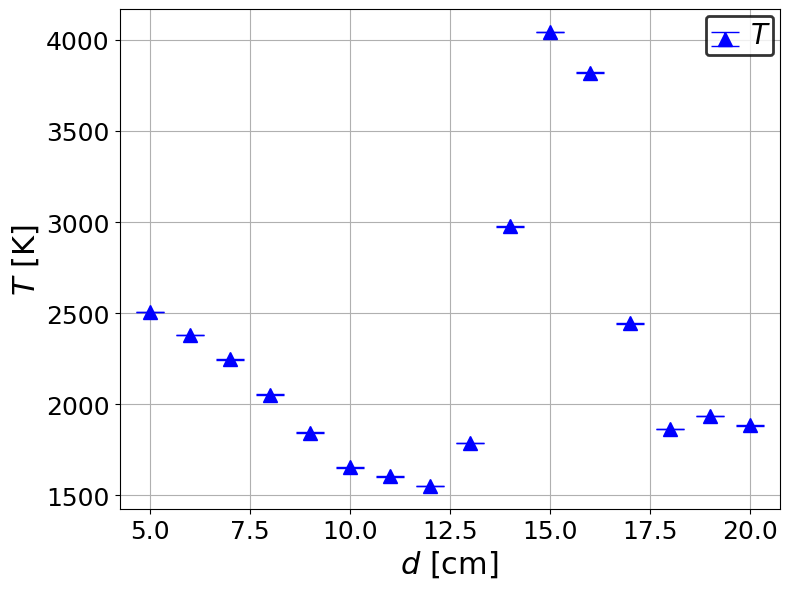

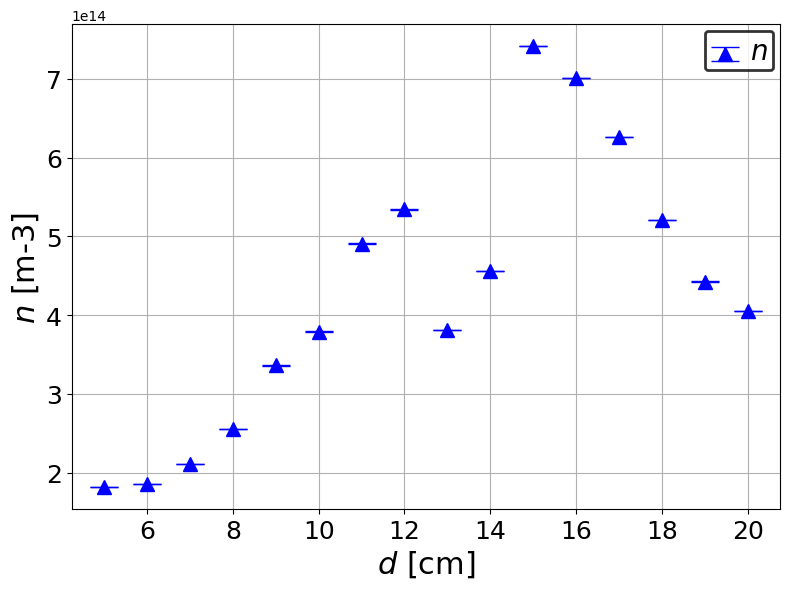

TypeError: set_axis_and_tick_properties() missing 2 required positional arguments: 'xy_fontsize' and 'tick_fontsize'

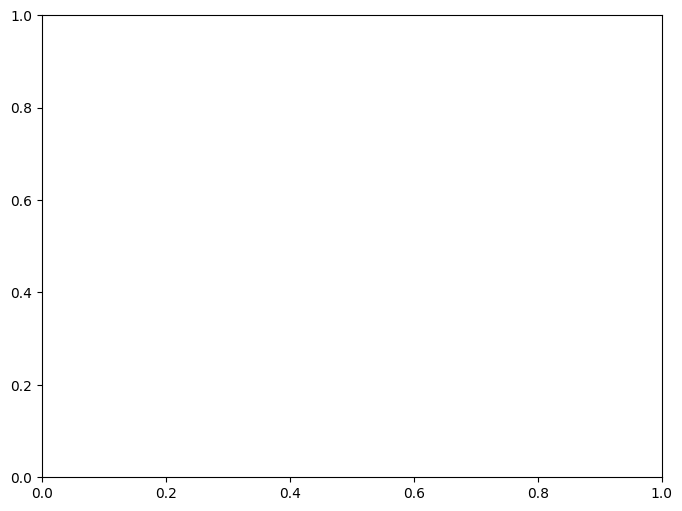

In [7]:
#Extract datas

Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]


for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L1/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)

# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 
dTs = np.zeros(len(Vs))
dns = np.zeros(len(Vs))

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 11900
    popt1, pcov1 = curve_fit(linear_fit, V[i1-3000:i1], ln_I[i1-3000:i1], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[5500:5700], ln_I[5500:5700], p0=[1, 1])


    V_P = (popt2[1] - popt1[1]) / (popt1[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1)
    
    #error on V_P
    b2 = popt2[1]
    db2 = pcov2[1][1]
    b1 = popt1[1]
    db1 = pcov1[1][1]
    a2 = popt2[0]
    da2 = pcov2[0][0]
    a1 = popt1[0]
    da1 = pcov1[0][0]
    dV_P = np.abs((db2 + db1)/(a1-a2)) + np.abs((b1-b2)/(a1-a2)**2 * (da1 + da2))
    
    
    dln_I_P =V_P*pcov1[0][0] + pcov1[1][1] + popt1[0]*dV_P
    
    
    
    # print(f'V_P = {V_P:.2f} +/- {dV_P:.2f} V')
    # print(f'ln_I_P = {ln_I_P:.2f} +/- {dln_I_P}')
    
    I_es = np.exp(ln_I_P)
    dI_es = np.exp(ln_I_P) * dln_I_P   
    
    # print(f'I_es = {I_es:.2e} +/- {dI_es:.2e} A')

    s = popt2[0]
    ds = pcov2[0][0]
    #error on I_es
    T = e / (kb * s)
    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * I_es
    
    dT = T * np.abs(ds / s) 
    dn = n * (dI_es / I_es + 0.5 * dT / T)
    
    # print(f'T = {T:.2f} +/- {dT:.2f} K')
    # print(f'n = {n:.2e} +/- {dn:.2e} m-3')

    dTs[i] = dT
    dns[i] = dn

    Ts[i] = T
    ns[i] = n
    
    # ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    # ax.plot(V[0:i1], ln_I[0:i1], label=f'$d = {i+5} cm$')
    # ax.plot(V, linear_fit(V, *popt1), 'r--')
    # ax.plot(V, linear_fit(V, *popt2), 'r--')

    # ax.set_ylim(-16, -8)

    # u.set_legend_properties(ax)

    # plt.show()

    # print(f'T = {T:.2f} K')
    # print(f'n = {n:.2e} cm-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
# ax.plot(np.arange(5, 21), Ts)
ax.errorbar(np.arange(5, 21), Ts, yerr=dTs, fmt='^', label='T', color='blue', markersize=10, capsize=10,capthick=1)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
# ax.plot(np.arange(5, 21), ns)
ax.errorbar(np.arange(5, 21), ns, yerr=dns, fmt='^', label='n', color='blue', markersize=10, capsize=10,capthick=1)
u.set_legend_properties(ax)
plt.show()


fig, ax1 = plt.subplots(figsize=(8, 6))
u.set_axis_and_tick_properties(ax1, x_label='$d$ [cm]', y_label='$T$ [K]')
color = 'blue'
ax1.errorbar(np.arange(5, 21), Ts, yerr=dTs, xerr = d_err, fmt='+', color=color, markersize=10, capsize=10, capthick=1, label ="Electron temperature")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
u.set_axis_and_tick_properties(ax2, x_label='$d$ [cm]', y_label='$n$ [m-3]')
color = 'red'
ax2.set_ylabel('$n$ [m-3]', color=color)  # we already handled the x-label with ax1
ax2.errorbar(np.arange(5, 21), ns, yerr=dns, xerr = d_err,fmt='x',  color=color, markersize=10, capsize=10, capthick=1,label ="Electron density")
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid()
# ax2.grid()

u.set_legend_properties(ax1)
u.set_legend_properties(ax2,loc=(0, 0.8))

fig.tight_layout()  # to prevent overlap of labels
plt.show()

# Langmuir 2
$p = 4.6e^{-2}$ mbar

$I = 0.03$ A

$f = 74.9$ Hz

<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2546/946895036.py:24: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'
/tmp/ipykernel_2546/946895036.py:35: RuntimeWarning: invalid value encountered in log
  ln_I = np.log(I)


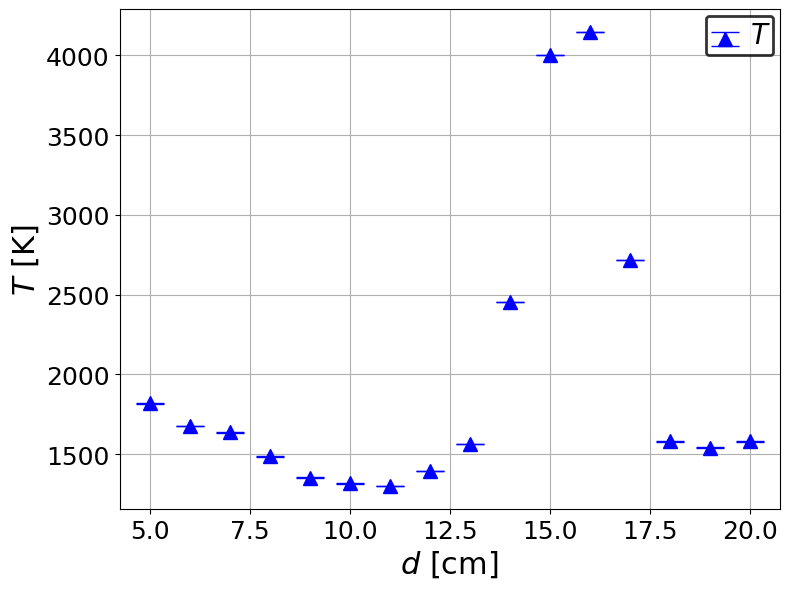

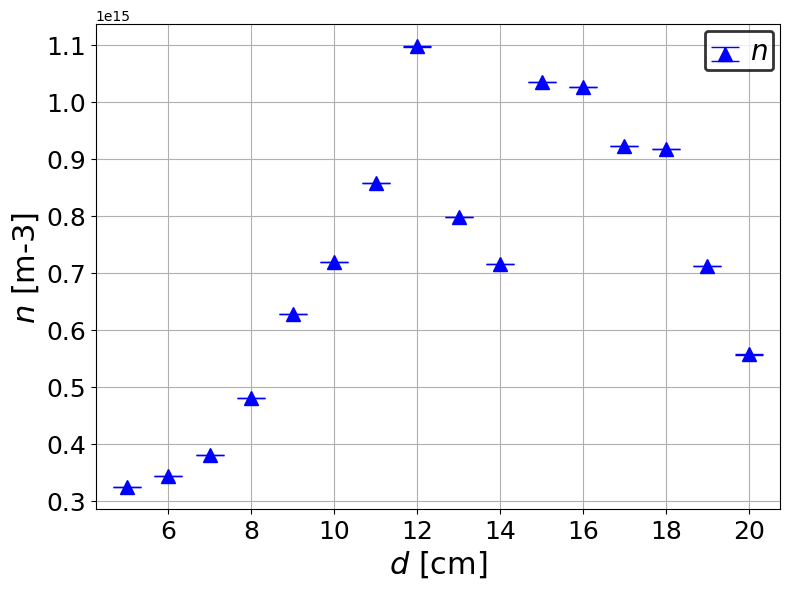

/tmp/ipykernel_2546/946895036.py:24: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'


TypeError: set_axis_and_tick_properties() missing 2 required positional arguments: 'xy_fontsize' and 'tick_fontsize'

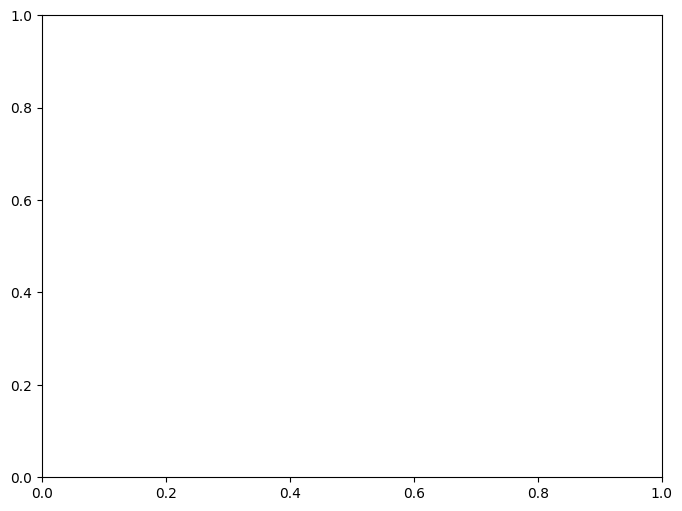

In [8]:
#Extract datas

Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]

for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L2/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)

# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 
for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 12000
    i0 = 24000

    popt1, pcov1 = curve_fit(linear_fit, V[i1-3000:i1], ln_I[i1-3000:i1], p0=[1, 1])

    popt1_1, pcov1_1 = curve_fit(linear_fit, V[i1:i1+3000], ln_I[i1:i1+3000], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[5650:5800], ln_I[5650:5800], p0=[1, 1])

    popt1_moy = (popt1 + popt1_1) / 2
    pcov1_moy = (pcov1 + pcov1_1) / 2
    
    V_P = (popt2[1] - popt1_moy[1]) / (popt1_moy[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1_moy)
    ln_I_P_1 = linear_fit(V_P, *popt1)
    d_ln_I_P = np.abs(ln_I_P - ln_I_P_1)

    
    # print(f'ln_I_P = {ln_I_P:.2f} +/- {d_ln_I_P}')

    s = popt2[0]
    ds = pcov2[0][0]
    
    T = e / (kb * s)
    dT = T * np.abs(ds/s)

    Ies = np.exp(ln_I_P)
    dIes = np.exp(ln_I_P) * d_ln_I_P
    
    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * Ies
    dn = n * (dI_es / I_es + 0.5 * dT / T)

    Ts[i] = T
    ns[i] = n
    
    # print(f'T = {T:.2f} +/- {dT:.2f} K')
    # print(f'n = {n:.2e} +/- {dn:.2e} m-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.errorbar(np.arange(5, 21), Ts, yerr=dTs, fmt='^', label='T', color='blue', markersize=10, capsize=10, capthick=1)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.errorbar(np.arange(5, 21), ns, yerr=dns, fmt='^', label='n', color='blue', markersize=10, capsize=10, capthick=1)
u.set_legend_properties(ax)
plt.show()
fig, ax1 = plt.subplots(figsize=(8, 6))
u.set_axis_and_tick_properties(ax1, x_label='$d$ [cm]', y_label='$T$ [K]')
color = 'blue'
ax1.errorbar(np.arange(5, 21), Ts, yerr=dTs,xerr = d_err, fmt='+', color=color, markersize=10, capsize=10, capthick=1, label="Electron temperature")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
u.set_axis_and_tick_properties(ax2, x_label='$d$ [cm]', y_label='$n$ [m-3]')
color = 'red'
ax2.set_ylabel('$n$ [m-3]', color=color)  # we already handled the x-label with ax1
ax2.errorbar(np.arange(5, 21), ns, yerr=dns, xerr = d_err,fmt='x', color=color, markersize=10, capsize=10, capthick=1,label="Electron density")
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid()

u.set_legend_properties(ax1,loc=(0, 0.72))
u.set_legend_properties(ax2,loc=(0, 0.82))

fig.tight_layout()  # to prevent overlap of labels
plt.show()

# Langmuir 3
$p = 6.0e^{-2}$ mbar

$I = 0.03$ A

$f = 74.9$ Hz

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2546/1295712780.py:23: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_{probe})$ [a.u.]'


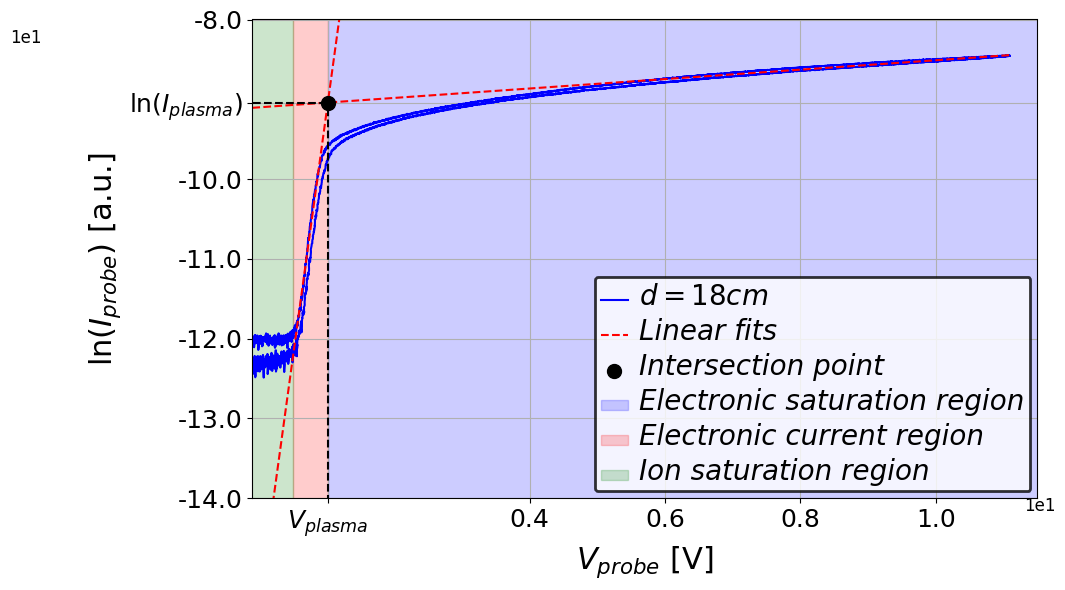

T = 1875.51 +/- 0.83 K
n = 1.15e+15 +/- 5.34e+13 m-3


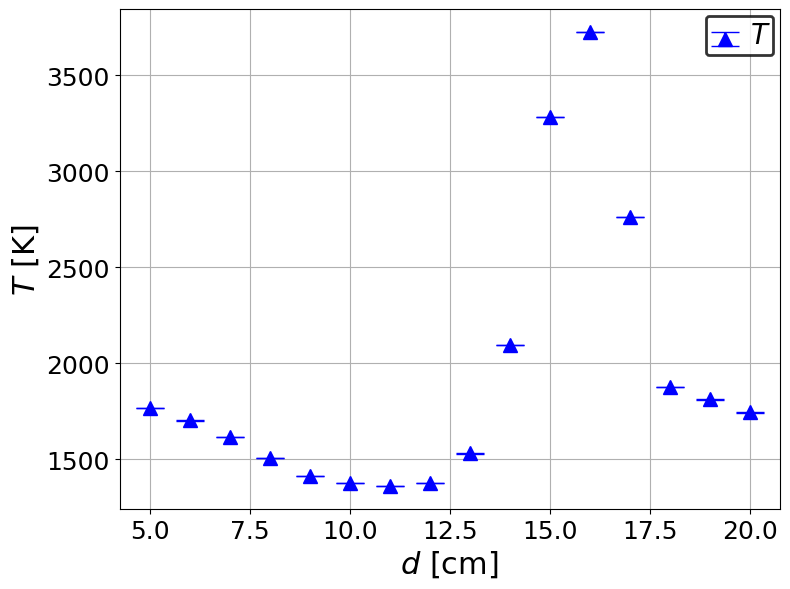

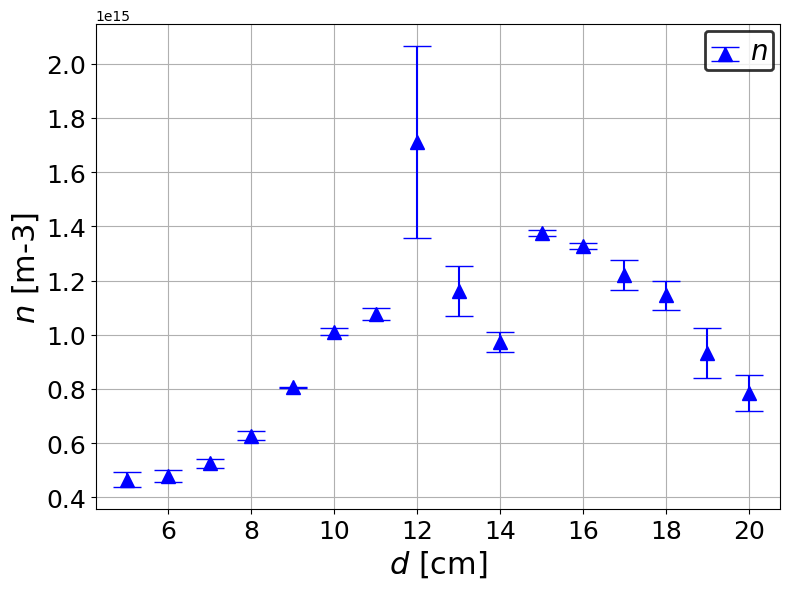

/tmp/ipykernel_2546/1295712780.py:23: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_{probe})$ [a.u.]'


TypeError: set_axis_and_tick_properties() missing 2 required positional arguments: 'xy_fontsize' and 'tick_fontsize'

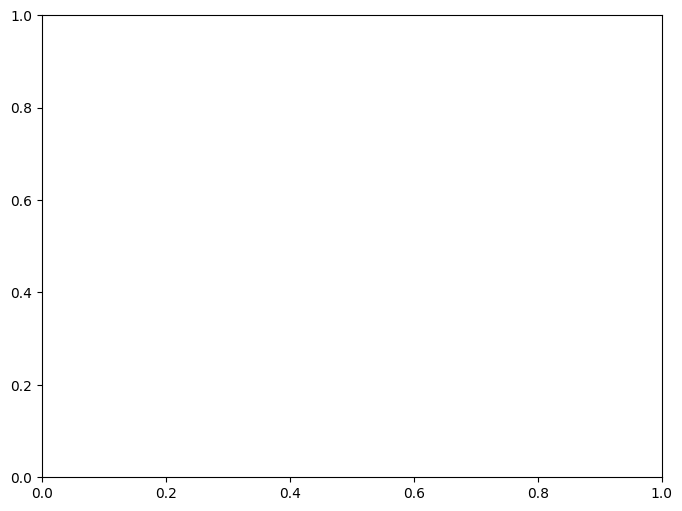

In [9]:
#Extract datas
Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]

for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L3/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)

# Plot

xlabel = '$V_{probe}$ [V]'
ylabel = '$\ln(I_{probe})$ [a.u.]'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 
dTs = np.zeros(len(Vs))
dns = np.zeros(len(Vs))

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 12000
    i0 = 24000
    popt1, pcov1 = curve_fit(linear_fit, V[i1-3000:i1], ln_I[i1-3000:i1], p0=[1, 1])

    popt1_1, pcov1_1 = curve_fit(linear_fit, V[i1:i1+3000], ln_I[i1:i1+3000], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[5600:5800], ln_I[5600:5800], p0=[1, 1])

    popt1_moy = (popt1 + popt1_1) / 2
    pcov1_moy = (pcov1 + pcov1_1) / 2

    V_P = (popt2[1] - popt1_moy[1]) / (popt1_moy[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1_moy)
    ln_I_P_1 = linear_fit(V_P, *popt1)
    d_ln_I_P = np.abs(ln_I_P - ln_I_P_1)

    s = popt2[0]
    ds = pcov2[0][0]
    
    T = e / (kb * s)
    dT = T * np.abs(ds/s)

    Ies = np.exp(ln_I_P)
    dIes = np.exp(ln_I_P) * d_ln_I_P
    
    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * Ies
    dn = n * (dIes / Ies + 0.5 * dT / T)

    Ts[i] = T
    ns[i] = n
    dTs[i] = dT
    dns[i] = dn
    
    if i ==13 :
        ax,fig = u.create_figure_and_apply_format((10,6),xlabel=xlabel, ylabel=ylabel)
        ax.plot(V[0:i0], ln_I[0:i0], label=f'$d = {i+5} cm$', color='blue')
        # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1), color ='orange', linestyle='--')
        # ax.plot(V[i1:i0], linear_fit(V[i1:i0], *popt1_1), color ='orange', linestyle='--')
        ax.plot(V[0:i1], linear_fit(V[0:i1], *popt2), 'red',  linestyle='--', label = 'Linear fits')
        ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1_moy), 'red', linestyle='--')
        ax.scatter(V_P, ln_I_P, color='black', label ="Intersection point", s=100,zorder = 10)
        
        ax.set_ylim(-13.5, -8)
        ax.set_xlim(-0.1,11)
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        x0 -=10
        y0 -= 10
        x1+=10
        y1+=10
        
        ax.hlines(ln_I_P,-10, V_P, color='black', linestyle='--')
        ax.vlines(V_P, y0,ln_I_P, color='black', linestyle='--')
        
        u.add_ticks('x',[V_P],[r'$V_{plasma}$'],ax = ax)
        u.add_ticks('y',[ln_I_P],[r'$\ln(I_{plasma})$'],ax = ax)
        
        u.remove_ticks('x',[1,2],ax=ax)
        u.remove_ticks('y',[5],ax=ax)
        
        V_is =0.5
        ax.fill_betweenx([y0, y1], V_P, x1, color='blue', alpha=0.2,label = 'Electronic saturation region')
        ax.fill_betweenx([y0, y1], V_is, V_P, color='red', alpha=0.2,label = 'Electronic current region')
        ax.fill_betweenx([y0, y1], x0, V_is, color='green', alpha=0.2,label = 'Ion saturation region')
        
        
        u.set_legend_properties(ax)

        
        ax.set_xlim(-0.1,11.5)
        
        
        plt.show()
        


        print(f'T = {T:.2f} +/- {dT:.2f} K')
        print(f'n = {n:.2e} +/- {dn:.2e} m-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.errorbar(np.arange(5, 21), Ts, yerr=dTs, fmt='^', label='T', color='blue', markersize=10, capsize=10, capthick=1)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.errorbar(np.arange(5, 21), ns, yerr=dns, fmt='^', label='n', color='blue', markersize=10, capsize=10, capthick=1)
u.set_legend_properties(ax)
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 6))
u.set_axis_and_tick_properties(ax1, x_label='$d$ [cm]', y_label='$T$ [K]')
color = 'blue'
ax1.errorbar(np.arange(5, 21), Ts, yerr=dTs, xerr=d_err, fmt='+', color=color, markersize=10, capsize=10, capthick=1, label="Electron temperature")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
u.set_axis_and_tick_properties(ax2, x_label='$d$ [cm]', y_label='$n$ [m-3]')
color = 'red'
ax2.set_ylabel('$n$ [m-3]', color=color)  # we already handled the x-label with ax1
ax2.errorbar(np.arange(5, 21), ns, yerr=dns, xerr=d_err, fmt='x', color=color, markersize=10, capsize=10, capthick=1, label="Electron density")
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid()

y01,y1 = ax1.get_ylim()
y1 += 0.15 * y1
ax1.set_ylim(y01, y1)

y02,y2 = ax2.get_ylim()
y2 += 0.15 * y2
ax2.set_ylim(y02, y2)

u.set_legend_properties(ax1, loc=(0, 0.82))
u.set_legend_properties(ax2, loc=(0, 0.92))

fig.tight_layout()  # to prevent overlap of labels
plt.show()

## Langmuir 4
$p = 4.1e^{-2}$ mbar

$I = 0.03$ A

$f = 144.6$ Hz


<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2546/3027656642.py:25: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'


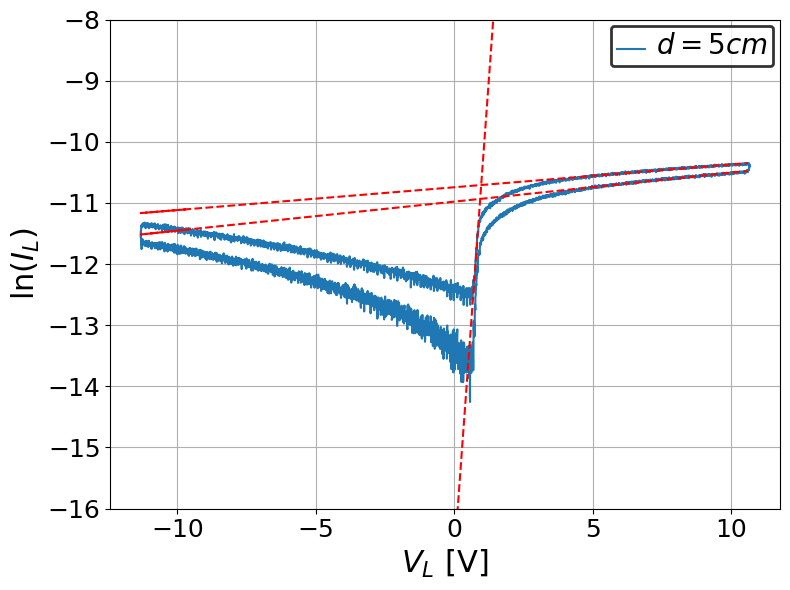

T = 1859.75 K
n = 1.94e+14 cm-3


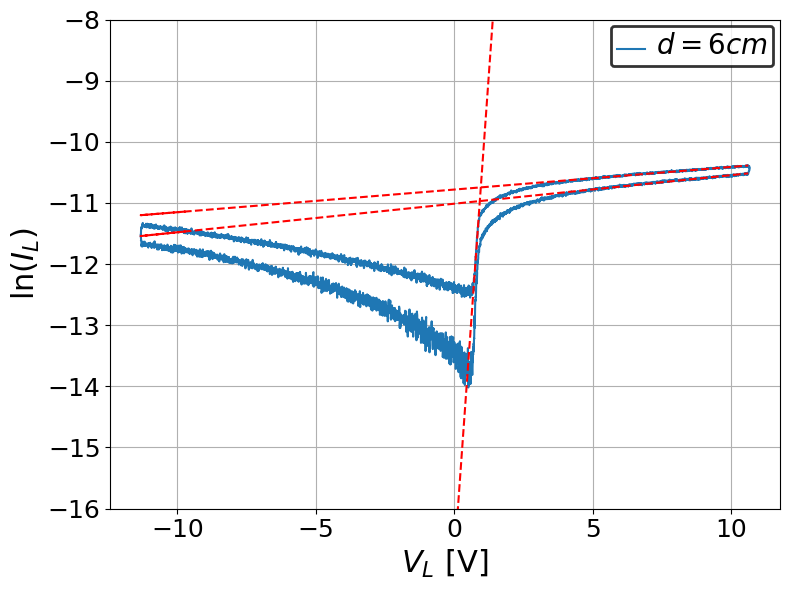

T = 1827.45 K
n = 1.89e+14 cm-3


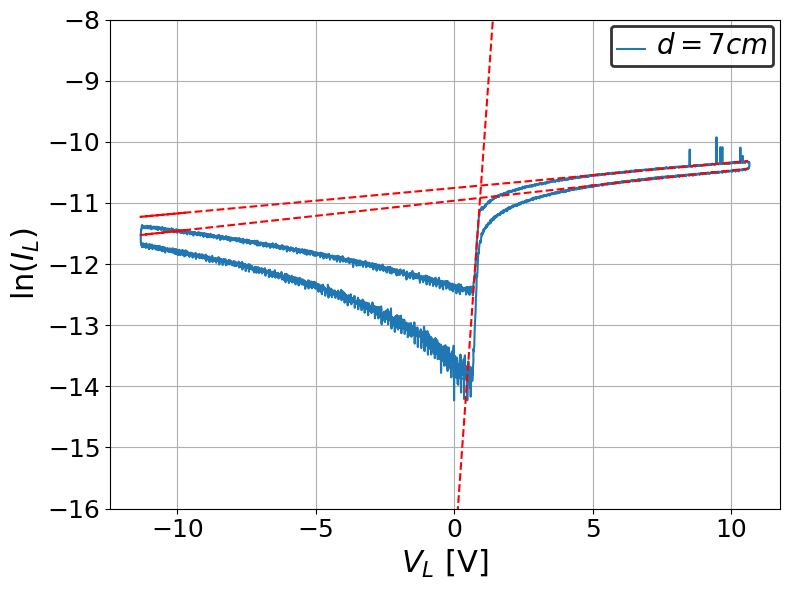

T = 1832.57 K
n = 1.96e+14 cm-3


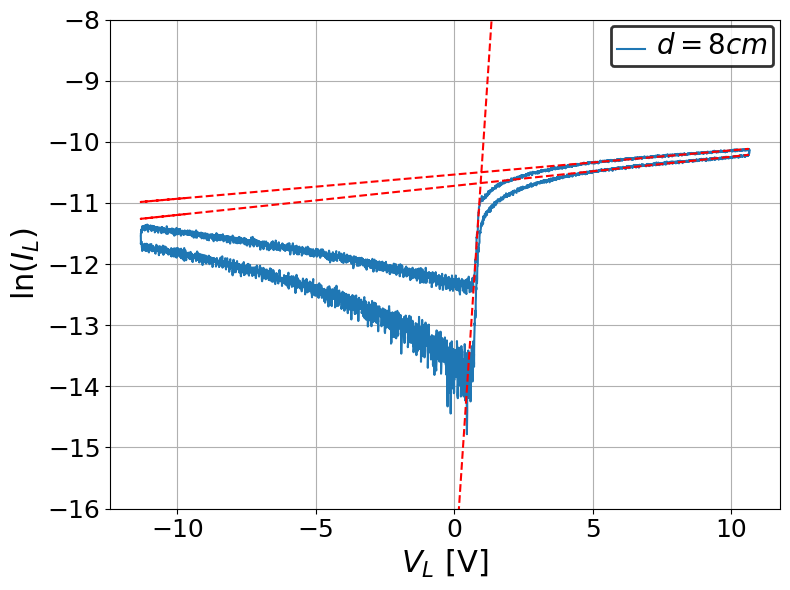

T = 1711.01 K
n = 2.56e+14 cm-3


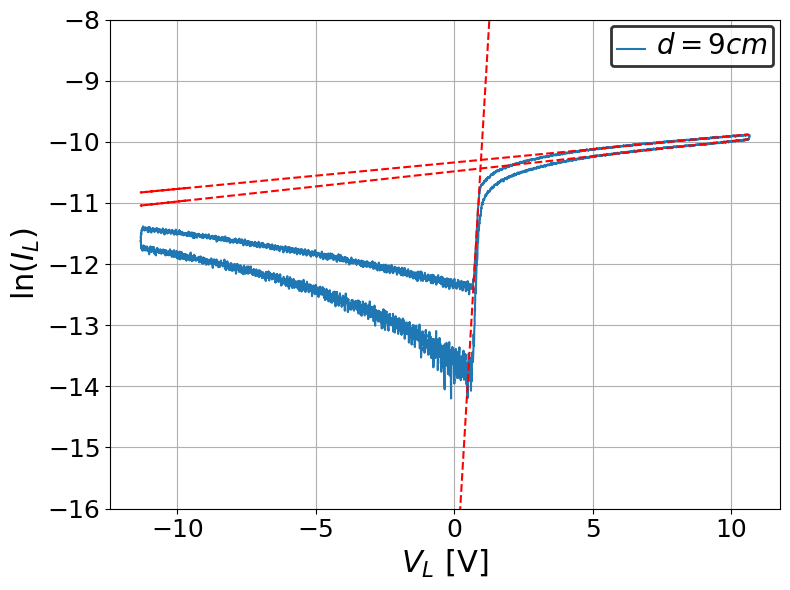

T = 1525.90 K
n = 3.38e+14 cm-3


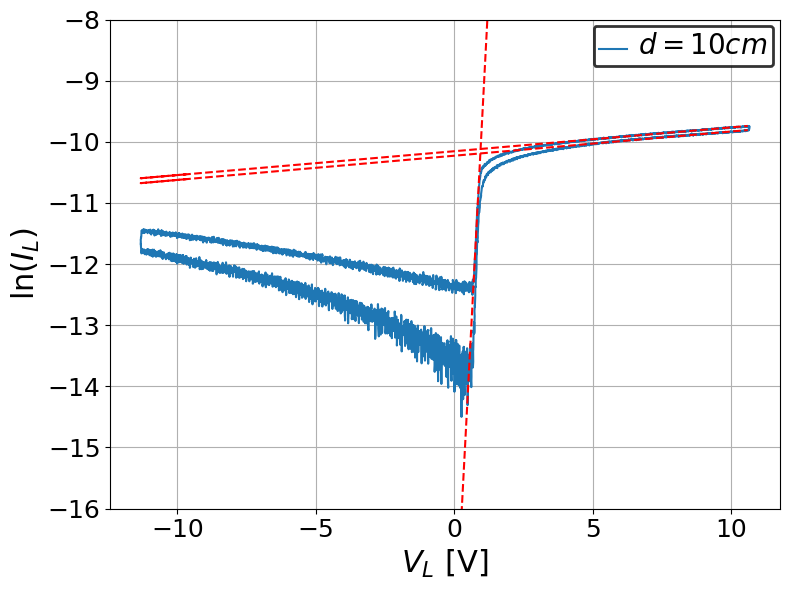

T = 1337.45 K
n = 4.46e+14 cm-3


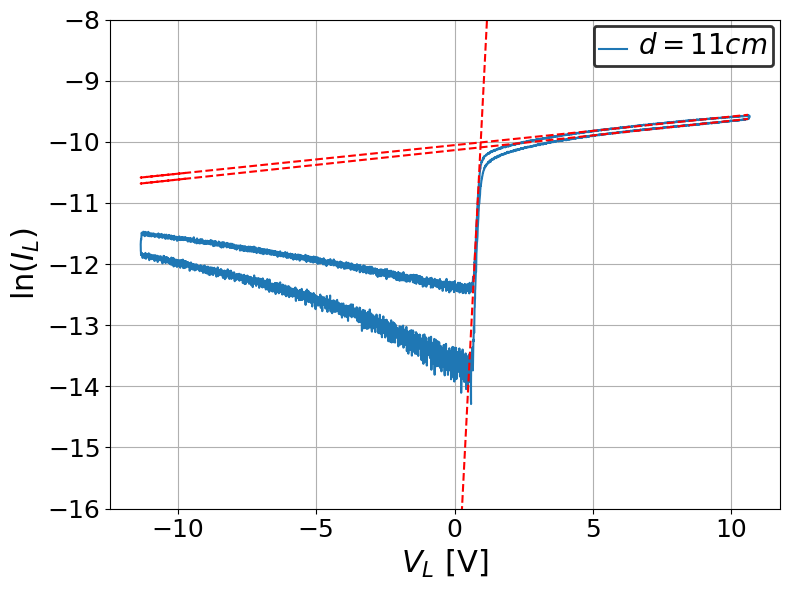

T = 1309.37 K
n = 5.00e+14 cm-3


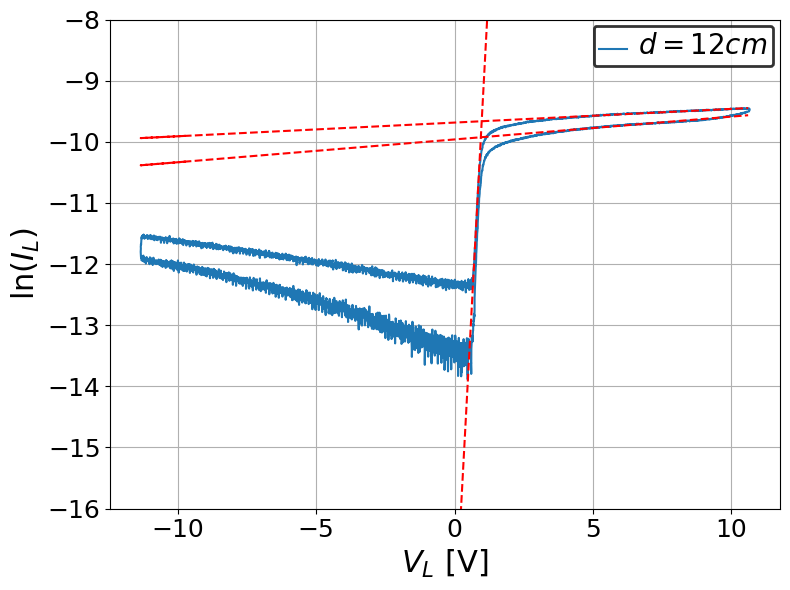

T = 1366.98 K
n = 6.32e+14 cm-3


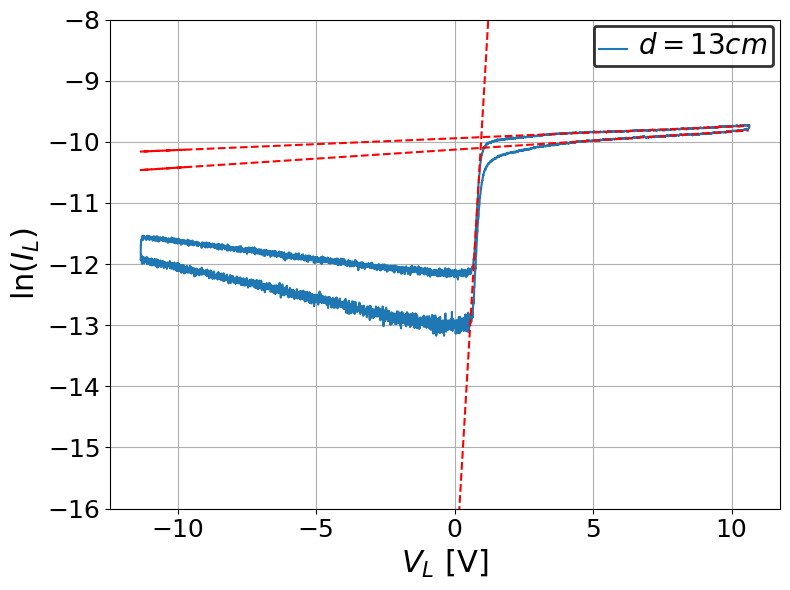

T = 1513.80 K
n = 4.83e+14 cm-3


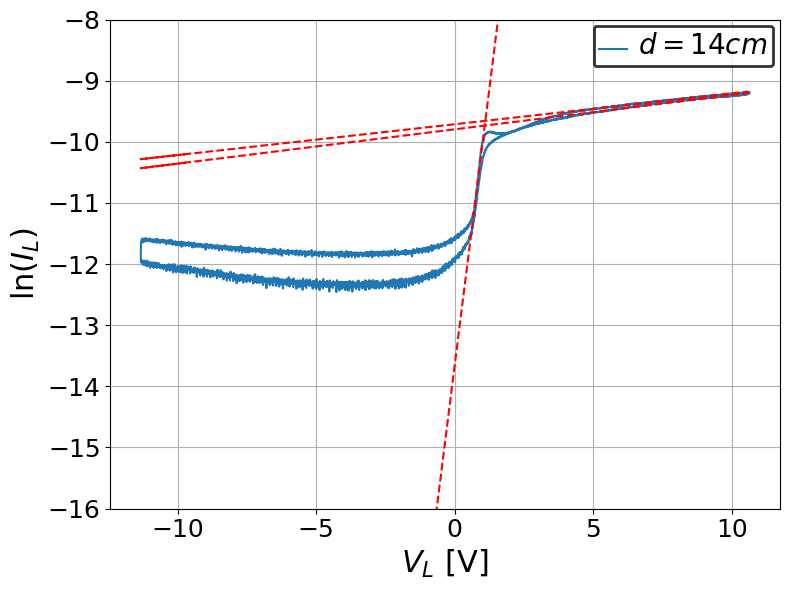

T = 3208.18 K
n = 4.55e+14 cm-3


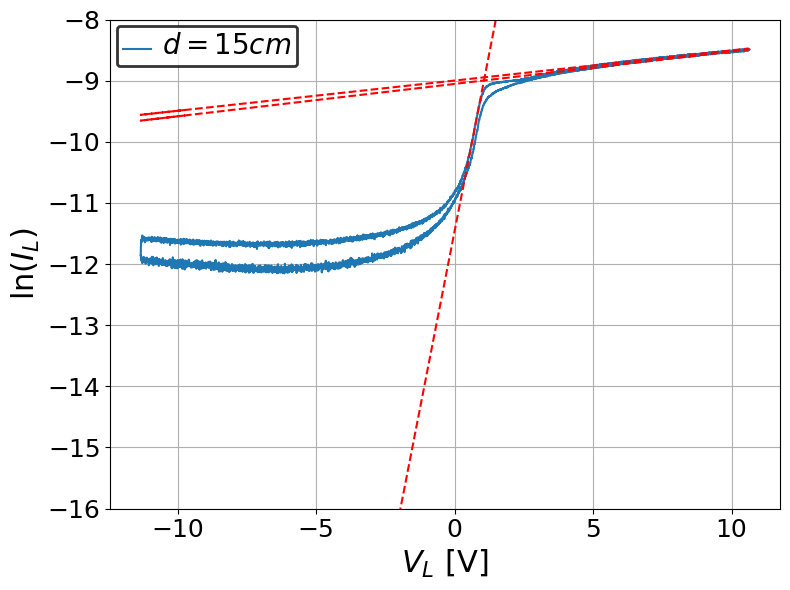

T = 4994.59 K
n = 7.53e+14 cm-3


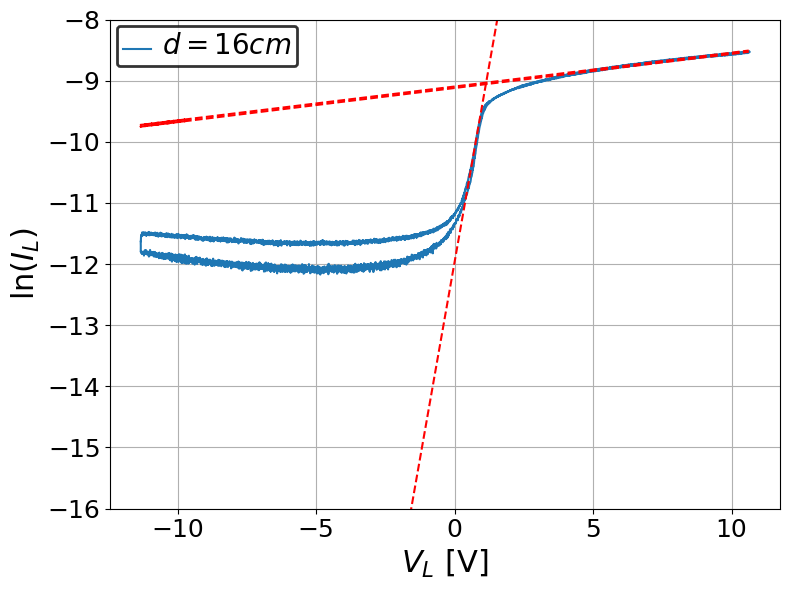

T = 4503.29 K
n = 7.37e+14 cm-3


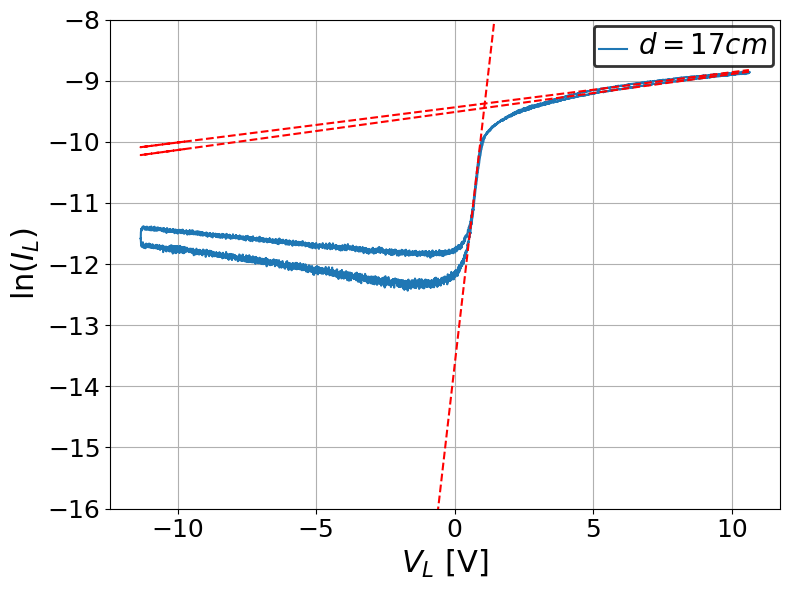

T = 2946.15 K
n = 6.32e+14 cm-3


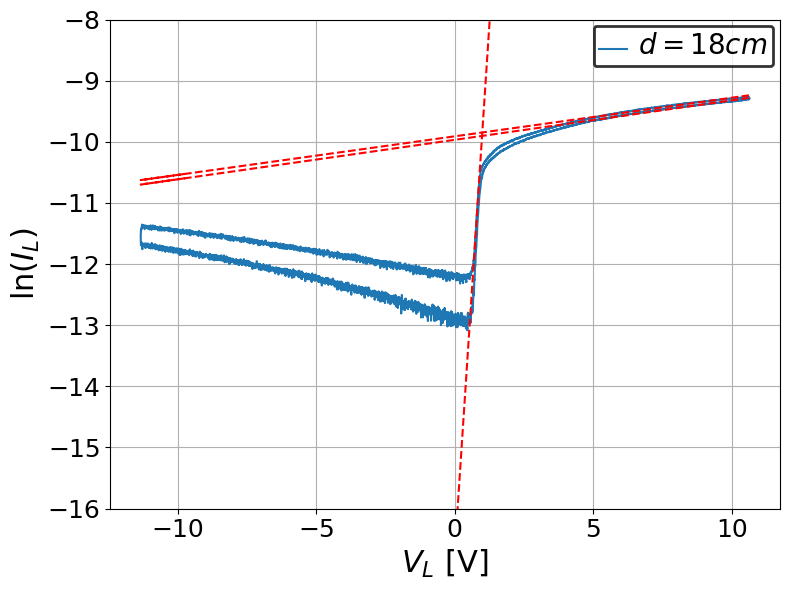

T = 1681.09 K
n = 5.25e+14 cm-3


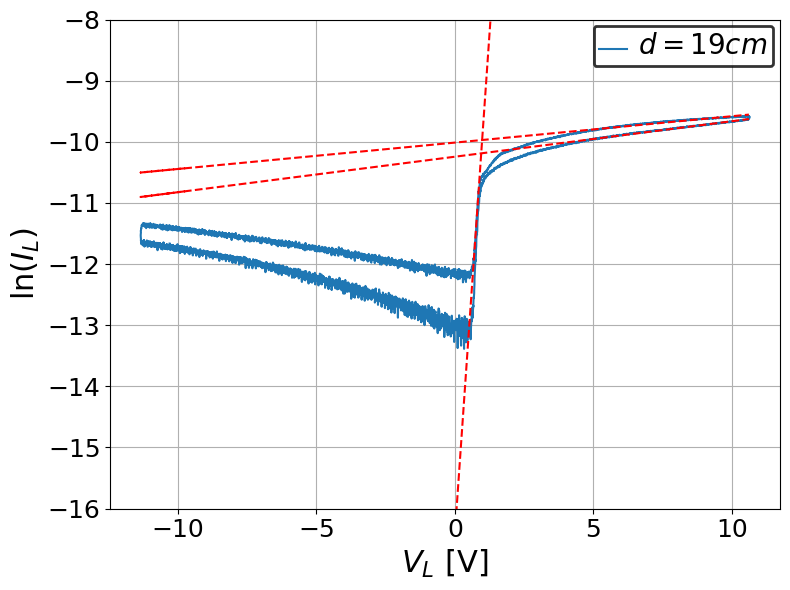

T = 1775.01 K
n = 4.17e+14 cm-3


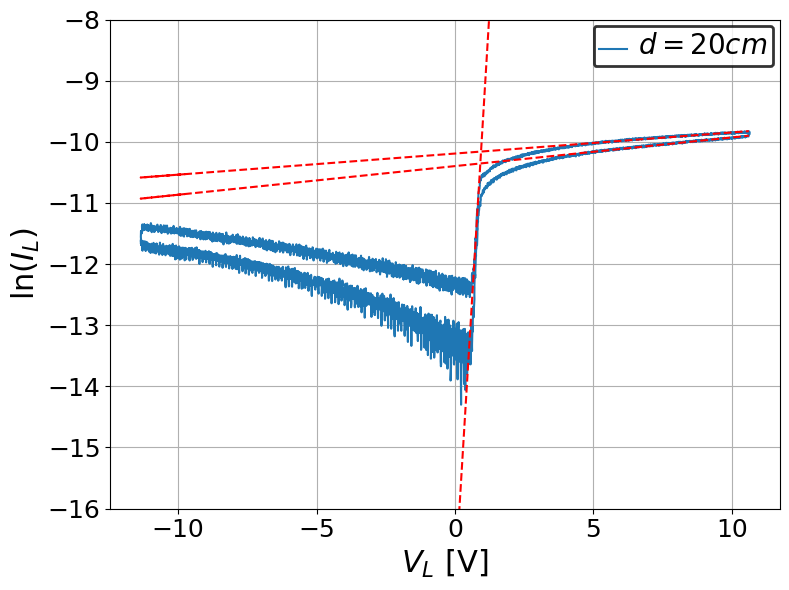

T = 1551.09 K
n = 3.73e+14 cm-3


/workspaces/TP3/utils_v2.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncol = ncol, loc = loc)


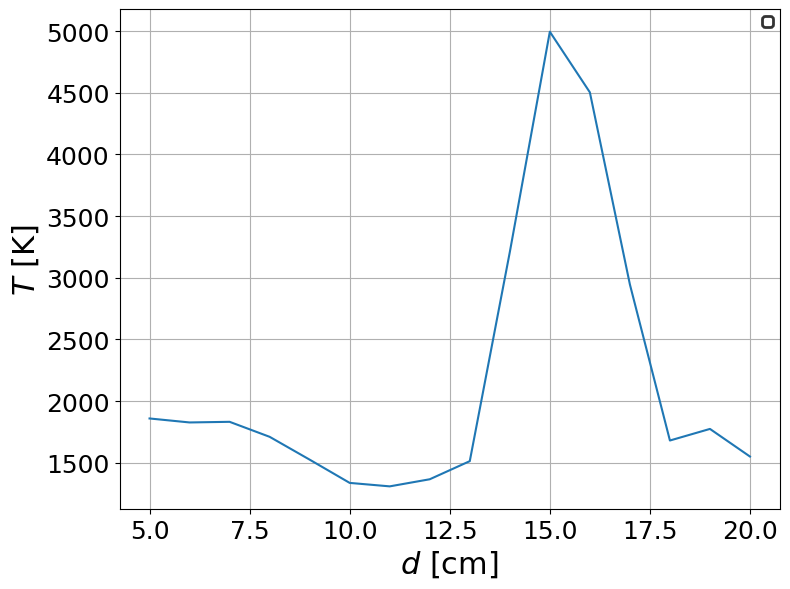

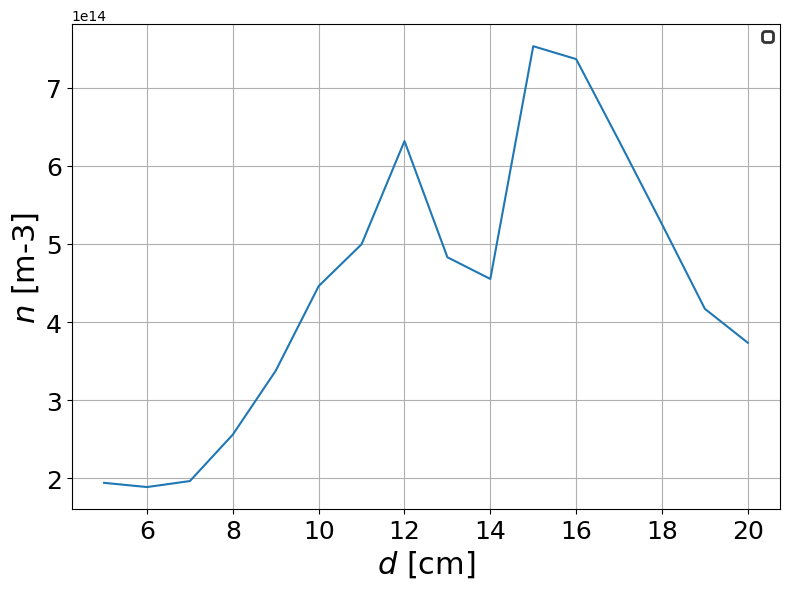

In [11]:
#Extract datas

Vs = [[] for _ in range(16)]
Is = [[] for _ in range(16)]

for i in range(1, 17):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L4/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)


# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 7400
    i0 = 14000

    popt1, pcov1 = curve_fit(linear_fit, V[i1-2000:i1], ln_I[i1-2000:i1], p0=[1, 1])

    popt1_1, pcov1_1 = curve_fit(linear_fit, V[i1+100:i1+2000], ln_I[i1+100:i1+2000], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[4300:4350], ln_I[4300:4350], p0=[1, 1])

    popt1_moy = (popt1 + popt1_1) / 2
    V_P = (popt2[1] - popt1_moy[1]) / (popt1_moy[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1_moy)

    T = e / (kb * popt2[0])

    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * np.exp(linear_fit(V_P, *popt2))

    Ts[i] = T
    ns[i] = n
    
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    ax.plot(V[0:i0], ln_I[0:i0], label=f'$d = {i+5} cm$')
    ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1), 'r--')
    ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1_1), 'r--')
    ax.plot(V[0:i1], linear_fit(V[0:i1], *popt2), 'r--')

    ax.set_ylim(-16, -8)

    u.set_legend_properties(ax)

    plt.show()

    print(f'T = {T:.2f} K')
    print(f'n = {n:.2e} cm-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.plot(np.arange(5, 21), Ts)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.plot(np.arange(5, 21), ns)
u.set_legend_properties(ax)
plt.show()

# Langmuir 5

$p = 5.2e^{-2}$ mbar

$I = 0.03$ A

$f = 144.7$ Hz

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2546/2017710257.py:26: SyntaxWarning: invalid escape sequence '\l'
  ylabel = '$\ln(I_L)$'
/workspaces/TP3/utils_v2.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncol = ncol, loc = loc)


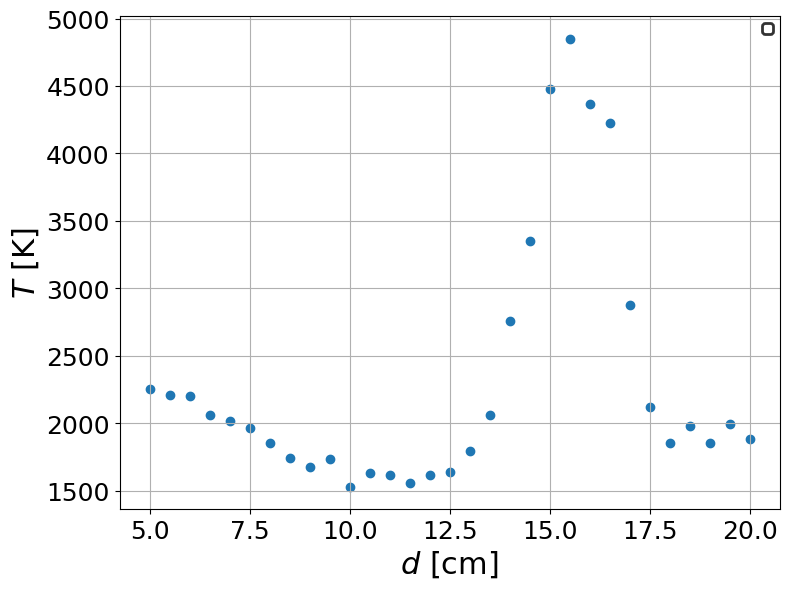

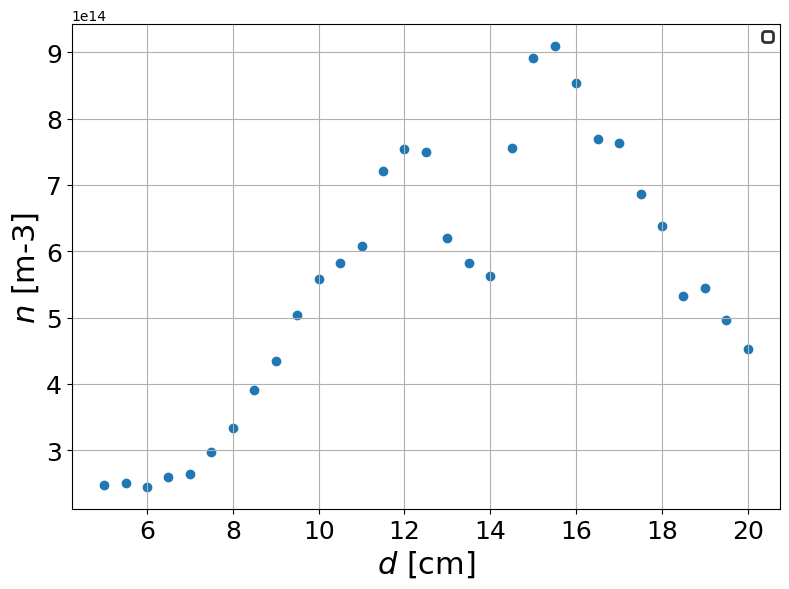

In [20]:
#Extract datas

Vs = [[] for _ in range(31)]
Is = [[] for _ in range(31)]
d = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]

for i in range(1, 32):
    if i < 10:
        j = '0' + str(i)
    else:
        j = str(i)
    data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/L5/I{j}.CSV', sep=',', decimal='.', header=1, usecols=[1, 2])

    V = data.iloc[:, 0].to_numpy()
    I = data.iloc[:, 1].to_numpy()
    V = V*15
    I = I * 0.5 * 1e-3

    Vs[i - 1].append(V)
    Is[i - 1].append(I)


# Plot

xlabel = '$V_L$ [V]'
ylabel = '$\ln(I_L)$'

e = 1.6e-19
me = 9.1e-31
kb = 1.38e-23
A = 9.6e-6
Ts = np.zeros(len(Vs))
ns = np.zeros(len(Vs)) 

for i in range (len(Vs)):
    V = Vs[i][0]
    I = Is[i][0]
    ln_I = np.log(I)

    for idx in range(len(ln_I)):
        if np.isnan(ln_I[idx]):
            ln_I[idx] = ln_I[idx - 1] if idx - 1 >= 0 else ln_I[idx + 1]

    i1 = 7400
    i0 = 14000

    popt1, pcov1 = curve_fit(linear_fit, V[i1-2000:i1], ln_I[i1-2000:i1], p0=[1, 1])

    popt1_1, pcov1_1 = curve_fit(linear_fit, V[i1+100:i1+2000], ln_I[i1+100:i1+2000], p0=[1, 1])

    popt2, pcov2 = curve_fit(linear_fit, V[4300:4400], ln_I[4300:4400], p0=[1, 1])

    popt1_moy = (popt1 + popt1_1) / 2
    V_P = (popt2[1] - popt1_moy[1]) / (popt1_moy[0] - popt2[0])
    ln_I_P = linear_fit(V_P, *popt1_moy)

    T = e / (kb * popt2[0])

    n = 1/(A * e) * np.sqrt(2 * np.pi * me / (kb * T)) * np.exp(linear_fit(V_P, *popt2))

    Ts[i] = T
    ns[i] = n
    
    # ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)
    # ax.plot(V[0:i0], ln_I[0:i0], label=f'$d = {i+5} cm$')
    # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1), 'r--')
    # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt1_1), 'r--')
    # ax.plot(V[0:i1], linear_fit(V[0:i1], *popt2), 'r--')

    # ax.set_ylim(-16, -8)

    # u.set_legend_properties(ax)

    # plt.show()

    # print(f'T = {T:.2f} K')
    # print(f'n = {n:.2e} cm-3')

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$T$ [K]')
ax.scatter(d, Ts)
u.set_legend_properties(ax)
plt.show()

ax,fig = u.create_figure_and_apply_format((8,6),xlabel='$d$ [cm]', ylabel='$n$ [m-3]')
ax.scatter(d, ns)
u.set_legend_properties(ax)
plt.show()